# Aquabreeding software for simulating aquatic breeding processes
Simulation includes the following steps:
- A founder population with {founder_size} individuals is generated.  The chromosome number, size (bp), and recombination rates are stored in {chrom}.
- SNPs of the founder population are generated by coalescent simulation.
- The effect sizes of the SNPs on the phenotype follow a normal distribution with mean 0 and variance {additive_var}.
- A progeny population with {progeny_size} individuals is generated by crossing the individuals of the founder population.
- The phenotypic values of the progeny individuals are calculated by summing the true breeding values and the environmental effects, the latter of which follows a normal distribution with mean 0 and variance {residual_var}.
- The breeding values of the progeny individuals are predicted with the numerator relationship matrix.  A restricted maximum likelihood method and EM algorithm are applied to predict breeding values and estimate the variance components.
- The founder population of the next generation is generated by selecting the progeny individuals with large predicted breeding values or phenotypic values.
- These processes are repeated until a user is satisfied.

## Parameter setting
The six parameters have to be set before running the simulation.
- {founder_size}: The number of individuals of a founder population.
- {progeny_size}: The number of individuals of a progeny population (less than 1,000 is recommended).
- {chrom}: tuple(the number of chromosomes, chromosome length (bp), crossing-over rate (cM/Mb)}.
- {n_snp}: The number of SNPs in a founder population.
- {additive_var}: The variance value of the effect sizes of SNPs.
- {residual_var}: The variance value of environmental factor.

## Other options
- Mating process: random mating or partial diallel cross (1 x 2)
- Selection scheme: based on predicted breeding values, based on phenotypes, or pedigree-based selection

## Output
Some statistics of a progeny population are obtained:
- Phenotypic values
- True breeding values
- Predicted breeding values
- Estimated additive and residual variance values
- Inbreeding coefficient (the proportion of identity-by-descent segments)

## Todo list
- All individuals are hermaphrodites. Sex will be incorporated.
- All SNPs have only additive effects.  Dominance and epistasis will be incorporated.
- Only partial diallel cross (1 x 2) can be applied.  Flexible mating function will be incorporated.
- The current version runs too slowly.  Speed up!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import aquabreeding as aq

## Example: Random mating and selection based on predicted breeding values

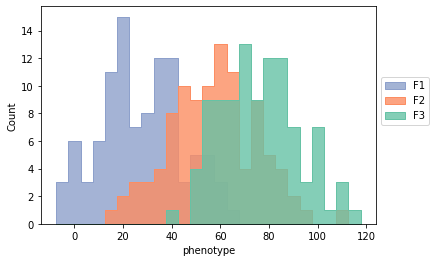

In [4]:
# NOTE: {progeny_size} has to be a multiple of {founder_size}

# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(
                founder_size=10, 
                progeny_size=100, 
                chrom=(3, 100_000_000, 1),
                n_snp=50, 
                additive_var=5.0, 
                residual_var=8.0)
aqua_bred.snp_info()

for g in range(3):  # simulate from F1 to F3
    # random mating
    aqua_bred.random_mating()
    
    # calculating phenotypic and breeding values
    # nrm: numerator relationship matrix
    # g_blup=True: enable to predict breeding values
    # ======
    # use_jit=True: use numba.jit to calculate a numerator
    #               relationship matrix
    #               but not use C++ library
    # ======
    aqua_bred.breeding_value_nrm(g_blup=True, use_jit=True)
    
    # get phenotype data
    record = pd.DataFrame([aqua_bred.pheno_v, [f'F{g+1}']*100]).transpose ()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    
    # select next founders based on breeding values
    aqua_bred.select_by_breeding_value()

sns.histplot(df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], binwidth=5, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor = (1, 0.7))
plt.show()

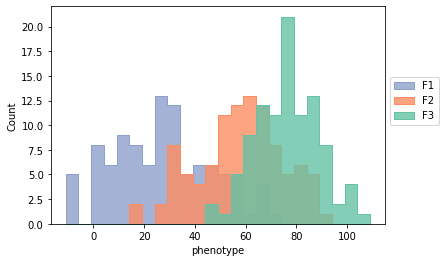

In [5]:
# NOTE: {progeny_size} has to be a multiple of {founder_size}

# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding(
                founder_size=10, 
                progeny_size=100, 
                chrom=(3, 100_000_000, 1),
                n_snp=50, 
                additive_var=5.0, 
                residual_var=8.0)
aqua_bred.snp_info()

for g in range(3):  # simulate from F1 to F3
    # random mating
    aqua_bred.random_mating()
    
    # calculating phenotypic and breeding values
    # nrm: numerator relationship matrix
    # g_blup=True: enable to predict breeding values
    # ======
    # use_jit=False: use C++ to calculate a numerator
    #               relationship matrix
    # ======
    aqua_bred.breeding_value_nrm(g_blup=True, use_jit=False)
    
    # get phenotype data
    record = pd.DataFrame([aqua_bred.pheno_v, [f'F{g+1}']*100]).transpose ()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    
    # select next founders based on breeding values
    aqua_bred.select_by_breeding_value()

sns.histplot(df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], binwidth=5, palette='Set2', element='step', alpha=0.8)
plt.legend(labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor = (1, 0.7))
plt.show()

# Under construction below

## Example: partial diallel cross and selection based on phenotypic values

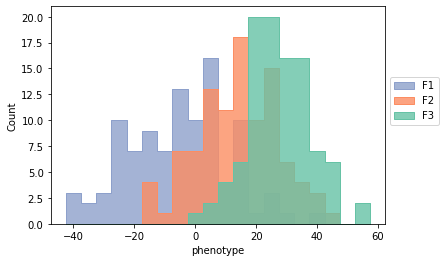

In [6]:
# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding (
                founder_size=10, 
                progeny_size=100, 
                chrom=(3, 100_000_000, 1),
                n_snp=50, 
                additive_var=5.0, 
                residual_var=8.0)
aqua_bred.snp_info ()

for g in range (3):  # simulate from F1 to F3
    # partial diallel cross
    aqua_bred.progeny_partial_diallel_mating ()
    
    # calculating phenotypic and breeding values
    # nrm: numerator relationship matrix
    # g_blup=False: disable to predict breeding values
    # because no need to calculate breeding values
    aqua_bred.breeding_value_nrm (g_blup='no')
    
    # get phenotype data
    record = pd.DataFrame ([aqua_bred.pheno_v, [f'F{g+1}']*100]).transpose ()
    record.columns = cols
    df1 = pd.concat ([df1, record], ignore_index=True)
    
    # select next founders based on phenotypes
    aqua_bred.select_by_phenotype ()

sns.histplot (df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], binwidth=5, palette='Set2', element='step', alpha=0.8)
plt.legend (labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor = (1, 0.7))
plt.show ()

## Example: partial diallel cross and pedigree-based selection

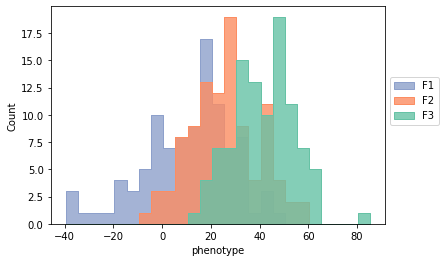

In [8]:
# NOTE: pedigree based selection can work only with parital diallel cross
# combination of random mating and pedigree based selection may not work correctly

# results are stored in pandas DataFrame
cols = ['phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding (
                founder_size=10, 
                progeny_size=100, 
                chrom=(3, 100_000_000, 1),
                n_snp=50, 
                additive_var=5.0, 
                residual_var=8.0)
aqua_bred.snp_info ()

for g in range (3):  # simulate from F1 to F3
    # partial diallel cross
    aqua_bred.progeny_partial_diallel_mating ()
    
    # calculating phenotypic and breeding values
    # nrm: numerator relationship matrix
    # g_blup=True: eable to predict breeding values
    aqua_bred.breeding_value_nrm (g_blup='EMMA')
    
    # get phenotype data
    record = pd.DataFrame ([aqua_bred.pheno_v, [f'F{g+1}']*100]).transpose ()
    record.columns = cols
    df1 = pd.concat ([df1, record], ignore_index=True)
    
    # select next founders based on pedigree
    aqua_bred.select_by_pedigree ()

sns.histplot (df1, x='phenotype', hue='Generation', hue_order=['F3', 'F2', 'F1'], binwidth=5, palette='Set2', element='step', alpha=0.8)
plt.legend (labels=['F1', 'F2', 'F3'], loc=2, bbox_to_anchor = (1, 0.7))
plt.show ()

## Phenotypic changes: breeding value-based selection vs. pedigree-based selecction

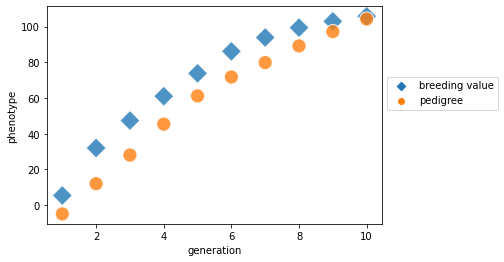

In [10]:
# it takes minutes

# results are stored in pandas DataFrame
cols = ['phenotype', 'generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# select by breeding values
for i in range (10):  # 10 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding (
                    founder_size=10, 
                    progeny_size=100, 
                    chrom=(3, 100_000_000, 1),
                    n_snp=50, 
                    additive_var=5.0, 
                    residual_var=8.0)
    aqua_bred.snp_info ()

    for g in range (10):  # simulate from F1 to F10
        # partial diallel cross
        aqua_bred.progeny_partial_diallel_mating ()
        
        # calculating phenotypic and breeding values
        aqua_bred.breeding_value_nrm (g_blup='EMMA')
        
        # get phenotype data
        record = pd.DataFrame ([[np.mean (aqua_bred.pheno_v), g, 'breeding value']], columns=cols)
        df1 = pd.concat ([df1, record], ignore_index=True)
        
        # select next founders based on breeding values
        aqua_bred.select_by_breeding_value ()

# select by pedigree
for i in range (10):  # 10 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding (
                    founder_size=10, 
                    progeny_size=100, 
                    chrom=(3, 100_000_000, 1),
                    n_snp=50, 
                    additive_var=5.0, 
                    residual_var=8.0)
    aqua_bred.snp_info ()
    
    for g in range (10):  # simulate from F1 to F10
        # partial diallel cross
        aqua_bred.progeny_partial_diallel_mating ()
        
        # calculating phenotypic and breeding values
        aqua_bred.breeding_value_nrm (g_blup='EMMA')
        
        # get phenotype data
        record = pd.DataFrame ([[np.mean (aqua_bred.pheno_v), g, 'pedigree']], columns=cols)
        df1 = pd.concat ([df1, record], ignore_index=True)
        
        # select next founders based on pedigree
        aqua_bred.select_by_pedigree ()

cols = ['generation', 'phenotype', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range (10):
    for j in ['breeding value', 'pedigree']:
        tmp = df1[(df1['generation']==g) & (df1['tag']==j)]
        #print (tmp)
        mean_phe = np.mean (tmp['phenotype'])
        record = pd.DataFrame([[g+1, mean_phe, j]], columns=cols)
        df2 = pd.concat ([df2, record], ignore_index=True)
#print (df2)
sns.scatterplot(x="generation", y="phenotype", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2)
plt.legend (loc=2, bbox_to_anchor = (1, 0.7))
plt.show ()

## breeding values, phenotypes, and variance components

Estimated additive genetic variance = 209.02958908539424
Estimated residual variance         = 71.3909056081012


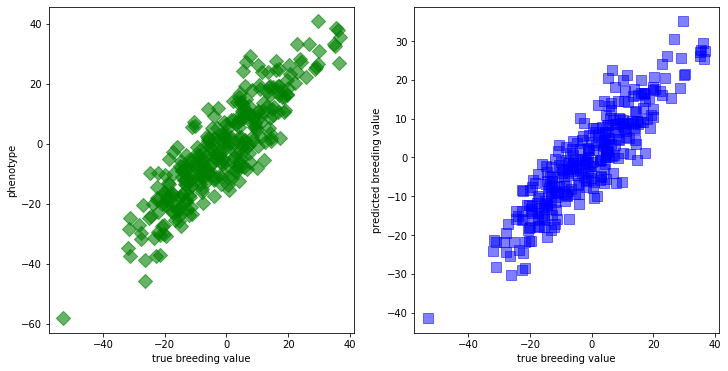

In [13]:
aqua_bred = aq.SimAquabreeding (
                founder_size=30, 
                progeny_size=300, 
                chrom=(3, 100_000_000, 1), # chrom num, bp, cM/Mb
                n_snp=50, 
                additive_var=5.0, 
                residual_var=8.0)
aqua_bred.snp_info ()
aqua_bred.progeny_random_mating ()
aqua_bred.breeding_value_nrm (g_blup='EMMA')

print (f'Estimated additive genetic variance = {aqua_bred.hat_vg}')
print (f'Estimated residual variance         = {aqua_bred.hat_ve}')

# true breeding value
tbv = aqua_bred.true_bv
# predicted breeding value
pbv = aqua_bred.hat_bv.ravel ()
# phynotypes
phenotype = aqua_bred.pheno_v

df = pd.DataFrame ([tbv, pbv, phenotype]).transpose ()
df.columns = ['true breeding value', 'predicted breeding value', 'phenotype']

#print (pbv)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
df.plot.scatter (x='true breeding value', y='phenotype', c='g', s=100, alpha=0.6, marker='D', ax=axes[0])
df.plot.scatter (x='true breeding value', y='predicted breeding value', c='b', s=100, alpha=0.5, marker=',', ax=axes[1])
plt.show ()

## Inbreeding coefficient

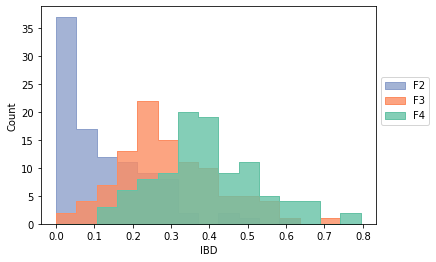

In [14]:
# choose random mating and breeding value-based selection

# results are stored in pandas DataFrame
cols = ['IBD', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding (
                founder_size=10, 
                progeny_size=100, 
                chrom=(3, 100_000_000, 1),
                n_snp=50, 
                additive_var=5.0, 
                residual_var=8.0)
aqua_bred.snp_info ()

for g in range (4):  # simulate from F1 to F4
    # random mating
    aqua_bred.progeny_random_mating ()
    
    # calculating phenotypic and breeding values
    aqua_bred.breeding_value_nrm (g_blup='EMMA')
    
    # get inbreeding coefficient
    if g > 0:  # F1 is discarded because prob. IBD = 0 in all progenies
        ibd = aqua_bred.calculate_ibd ()
        record = pd.DataFrame ([ibd, [f'F{g+1}']*100]).transpose ()
        record.columns = cols
        df1 = pd.concat ([df1, record], ignore_index=True)
    
    # select next founders based on breeding values
    aqua_bred.select_by_breeding_value ()

sns.histplot (df1, x='IBD', hue='Generation', hue_order=['F4', 'F3', 'F2'], bins=15, palette='Set2', element='step', alpha=0.8)
plt.legend (labels=['F2', 'F3', 'F4'], loc=2, bbox_to_anchor = (1, 0.7))
plt.show ()

## inbreeding coefficient: breeding value-based vs. pedigree-based selection

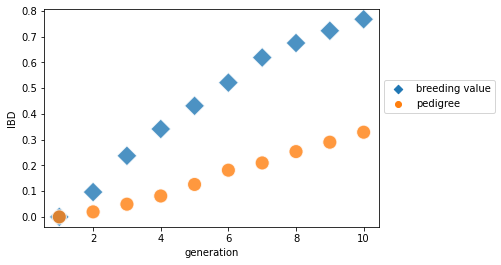

In [16]:
# it takes minutes

# results are stored in pandas DataFrame
cols = ['IBD', 'generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# select by breeding values
for i in range (10):  # 10 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding (
                    founder_size=10, 
                    progeny_size=100, 
                    chrom=(3, 100_000_000, 1),
                    n_snp=50, 
                    additive_var=5.0, 
                    residual_var=8.0)
    aqua_bred.snp_info ()

    for g in range (10):  # simulate from F1 to F10
        # partial diallel cross
        aqua_bred.progeny_partial_diallel_mating ()
        
        # calculating phenotypic and breeding values
        aqua_bred.breeding_value_nrm (g_blup='EMMA')
        
        # get inbreeding coefficient
        ibd = aqua_bred.calculate_ibd ()
        record = pd.DataFrame ([[np.mean (ibd), g, 'breeding value']], columns=cols)
        df1 = pd.concat ([df1, record], ignore_index=True)
        
        # select next founders based on breeding values
        aqua_bred.select_by_breeding_value ()

# select by pedigree
for i in range (10):  # 10 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding (
                    founder_size=10, 
                    progeny_size=100, 
                    chrom=(3, 100_000_000, 1),
                    n_snp=50, 
                    additive_var=5.0, 
                    residual_var=8.0)
    aqua_bred.snp_info ()
    
    for g in range (10):  # simulate from F1 to F10
        # partial diallel cross
        aqua_bred.progeny_partial_diallel_mating ()
        
        # calculating phenotypic and breeding values
        aqua_bred.breeding_value_nrm (g_blup='EMMA')
        
        # get inbreeding coefficient
        ibd = aqua_bred.calculate_ibd ()
        record = pd.DataFrame ([[np.mean (ibd), g, 'pedigree']], columns=cols)
        df1 = pd.concat ([df1, record], ignore_index=True)
        
        # select next founders based on pedigree
        aqua_bred.select_by_pedigree ()

cols = ['generation', 'IBD', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range (10):
    for j in ['breeding value', 'pedigree']:
        tmp = df1[(df1['generation']==g) & (df1['tag']==j)]
        #print (tmp)
        mean_phe = np.mean (tmp['IBD'])
        record = pd.DataFrame([[g+1, mean_phe, j]], columns=cols)
        df2 = pd.concat ([df2, record], ignore_index=True)

sns.scatterplot(x="generation", y="IBD", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2)
plt.legend (loc=2, bbox_to_anchor = (1, 0.7))
plt.show ()

## Theoretical expectation of inbreeding coefficient with random mating and no selection
$F_{t} = 1 - \left(1 - \frac{1}{2n}\right)^{t-1},$
where $F_{t}$ is inbreeding coefficient at $t$th generation and $n$ is the founder population size

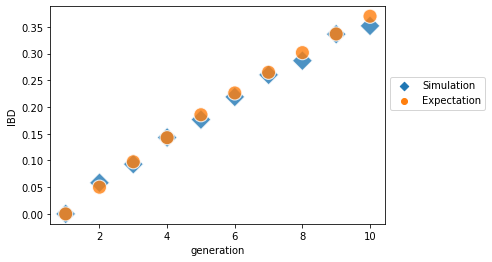

In [18]:
# it takes minutes

# results are stored in pandas DataFrame
cols = ['IBD', 'generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# select by breeding values
for i in range (10):  # 10 replicates
    # start new simulation
    # initial setting
    aqua_bred = aq.SimAquabreeding (
                    founder_size=10, 
                    progeny_size=100, 
                    chrom=(3, 100_000_000, 1),
                    n_snp=50, 
                    additive_var=5.0, 
                    residual_var=8.0)
    aqua_bred.snp_info ()

    for g in range (10):  # simulate from F1 to F10
        # random mating
        aqua_bred.progeny_random_mating ()
        
        # calculating phenotypic and breeding values
        aqua_bred.breeding_value_nrm (g_blup='no')
        
        # get inbreeding coefficient
        ibd = aqua_bred.calculate_ibd ()
        record = pd.DataFrame ([[np.mean (ibd), g, 'simulation']], columns=cols)
        df1 = pd.concat ([df1, record], ignore_index=True)
        
        # new founders are selected randomly
        aqua_bred.select_at_random ()

cols = ['generation', 'IBD', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range (10):
    tmp = df1[(df1['generation']==g)]
    #print (tmp)
    mean_phe = np.mean (tmp['IBD'])
    record = pd.DataFrame([[g+1, mean_phe, 'Simulation']], columns=cols)
    df2 = pd.concat ([df2, record], ignore_index=True)
    
# theoretical expectation
for g in range (10):
    T = g+1
    F = 1.0 - (19.0/20.0)**(T-1)
    record = pd.DataFrame ([[T, F, 'Expectation']], columns=cols)
    df2 = pd.concat ([df2, record], ignore_index=True)
    
sns.scatterplot(x="generation", y="IBD", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2)
plt.legend (loc=2, bbox_to_anchor = (1, 0.7))
plt.show ()

## Check see if recombination works

In [19]:
# start new simulation
# initial setting
aqua_bred = aq.SimAquabreeding (
                    founder_size=10, 
                    progeny_size=20, 
                    chrom=(2, 100_000_000, 1),
                    n_snp=50, 
                    additive_var=5.0, 
                    residual_var=8.0)
aqua_bred.snp_info ()

# print {n_show} founder individuals
print ('===========')
print ('chromosome = [[start segment, end segment, genotype], [start segment, end segment, genotype],...]')
print ('===========\nIndividual in the founder')
aqua_bred.print_population (target='founder', n_show=3)

aqua_bred.progeny_random_mating ()
print ('\n===========\nIndividual in the progeny')
aqua_bred.print_population (target='progeny', n_show=3)


chromosome = [[start segment, end segment, genotype], [start segment, end segment, genotype],...]
Individual in the founder
Individual ID = 0
  father = -1
  mother = -1
    0th chromosome
      [[1, 100000000, 0]]
      [[1, 100000000, 1]]
    1th chromosome
      [[1, 100000000, 0]]
      [[1, 100000000, 1]]
Individual ID = 1
  father = -1
  mother = -1
    0th chromosome
      [[1, 100000000, 2]]
      [[1, 100000000, 3]]
    1th chromosome
      [[1, 100000000, 2]]
      [[1, 100000000, 3]]
Individual ID = 2
  father = -1
  mother = -1
    0th chromosome
      [[1, 100000000, 4]]
      [[1, 100000000, 5]]
    1th chromosome
      [[1, 100000000, 4]]
      [[1, 100000000, 5]]

Individual in the progeny
Individual ID = -1
  father = 3
  mother = 6
    0th chromosome
      [[1, 100000000, 6]]
      [[1, 33862345, 12], [33862346, 71862139, 13], [71862140, 100000000, 12]]
    1th chromosome
      [[1, 13637990, 6], [13637991, 21180492, 7], [21180493, 95484641, 6], [95484642, 100000000, 